### HW6 Мельчук А.Б.

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

### Загрузка датасета LFW

In [0]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

Label: b'Tom_Amstutz'
Label: b'Kimi_Raikkonen'
Label: b'Pedro_Almodovar'
Label: b'John_Rosa'
Label: b'Jane_Rooney'
Label: b'Mike_Brey'
Label: b'Keith_Brown'
Label: b'Justin_Timberlake'
Label: b'Lleyton_Hewitt'
Label: b'Thomas_Wilkens'
Label: b'Ian_Thorpe'
Label: b'Christine_Todd_Whitman'
Label: b'Yekaterina_Guseva'
Label: b'George_W_Bush'
Label: b'Martha_Stewart'
Label: b'Jesse_James'
Label: b'John_Abizaid'
Label: b'Tim_Henman'
Label: b'Pieter_Bouw'
Label: b'Lance_Armstrong'
Label: b'John_Marburger'
Label: b'Al_Gore'
Label: b'Donald_Rumsfeld'
Label: b'Andy_Roddick'
Label: b'Jeremy_Greenstock'
Label: b'Junko_Tabei'
Label: b'Richard_Haass'
Label: b'Paul_Coppin'
Label: b'Dinah_Turner'
Label: b'George_W_Bush'
Label: b'Guenter_Verheugen'
Label: b'Princess_Elisabeth'
Label: b'Doug_Collins'
Label: b'Larry_Hahn'
Label: b'Natalie_Cole'
Label: b'Valery_Giscard_dEstaing'
Label: b'Gregory_Hines'
Label: b'Mitt_Romney'
Label: b'Ahmed_Chalabi'
Label: b'Lucio_Gutierrez'
Label: b'Bridgette_Wilson-Sampr

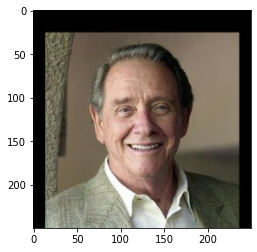

In [4]:
for example in train_ds.take(66):
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    print(f"Label: {label}")

### Создание модели CNN

In [0]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

### Contrastive Loss

In [0]:
MARGIN = 50.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

### Подготовка пайплайна данных

In [0]:
BATCH_SIZE = 128
NUM_EPOCHS = 10

def normal(label, image):
    return label, tf.cast(image, tf.float32) / 255.

train_ds = train_ds.map(normal)
train_ds = train_ds.shuffle(buffer_size=5000, seed=47)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

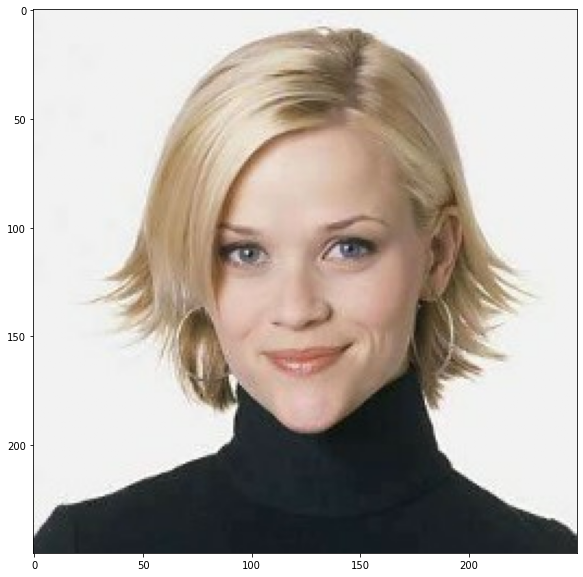

In [36]:
sample = next(iter(train_ds))
plt.figure(figsize=(10,10))
plt.imshow(sample[1].numpy()[1].reshape(250,250,3))

In [37]:
sample[0][1]

<tf.Tensor: shape=(), dtype=string, numpy=b'Reese_Witherspoon'>

### Подготовка к обучению

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

### Обучение модели

In [39]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 2474.66845703125
[200] Loss: 2.0607070922851562
[400] Loss: 0.0
[600] Loss: 0.7944478988647461
[800] Loss: 104.36817932128906
[1000] Loss: 0.0
CPU times: user 3min 43s, sys: 1min 5s, total: 4min 49s
Wall time: 5min 27s


### Тестирование на новых данных

In [0]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('/home/justin_timberlake.jpeg')
img_a2 = load_and_prepare_image('/home/justin_timberlake2.jpg')
img_b1 = load_and_prepare_image('/home/mel_gibson.jpg')



### Получение эмбеддингов для новых данных

In [0]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

### Вычисление расстояний между эмбеддингами

In [54]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:] #Justin Timberlake
emb2 = new_embs[1,:] #Justin Timberlake 2
emb3 = new_embs[2,:] #Mel Gibson


print('Justin <-> Justin2: ', diff(emb1, emb2))
print('Justin<-> Mel_Gibson: ', diff(emb1, emb3))
print('Justin2 <-> Mel_Gibson: ', diff(emb2, emb3))

Justin <-> Justin2:  0.0
Justin<-> Mel_Gibson:  62.23873125288424
Justin2 <-> Mel_Gibson:  69.12582292118663
